In [1]:
%matplotlib notebook

import numpy              as np
import matplotlib.pyplot  as plt
from scipy.interpolate    import interp1d
from scipy                import integrate
from scipy                import signal
from astropy.io           import fits
from scipy                import stats
from scipy                import optimize

<IPython.core.display.Javascript object>


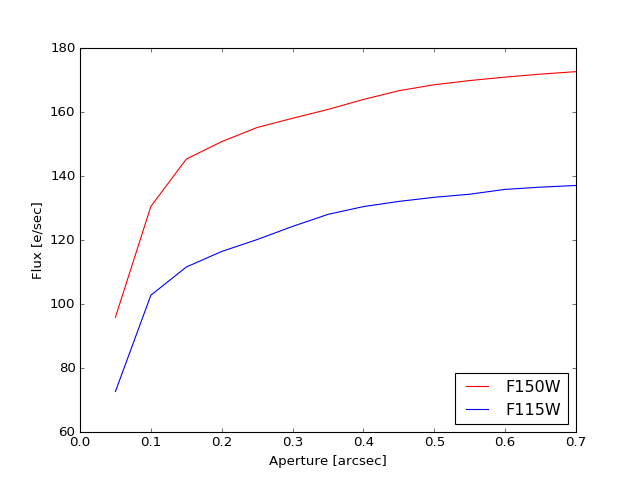

In [6]:
# point-source, emmited flux = 5e-6 Jy

fluxes_115=np.array([72.65, 102.74, 111.55, 116.42, 120.14, 124.24, 128.01,
                    130.44, 132.06, 133.34, 134.31, 135.82, 136.52, 137.04])
fluxes_150=np.array([95.84, 130.49, 145.29, 150.74, 155.16, 158.04, 160.80,
                    163.92, 166.65, 168.52, 169.83, 170.90, 171.84, 172.61]) # [e/sec]

Apertures = np.linspace(0.05,0.70,len(fluxes_115))  # max = 1.0 [in arcsec]

plt.figure(1)
plt.plot(Apertures,fluxes_150,'r',label='F150W')
plt.plot(Apertures,fluxes_115,'b',label='F115W')
plt.ylabel('Flux [e/sec]')
plt.xlabel('Aperture [arcsec]')
plt.legend(loc='lower right')


In [73]:
units = 1e23 * 1e9 / (10 ** (0.4 * (26.45 + 48.6)))

noise_low_background_115 = fits.open('data/noise_115_low_background.fits')[0].data
noise_low_background_150 = fits.open('data/noise_150_low_background.fits')[0].data

noise_low_background_115 /= 116 / 5e3 * units
noise_low_background_150 /= 151 / 5e3 * units

print('Background configuration: F115W')
print('    max       min     mean     std')
print(np.round(np.max(noise_low_background_115),7),np.round(np.min(noise_low_background_115),7),
      np.round(np.mean(noise_low_background_115),7),np.round(np.std(noise_low_background_115),7))
print(' ')
print('Background configuration: F150W')
print('    max       min     mean     std')
print(np.round(np.max(noise_low_background_150),7),np.round(np.min(noise_low_background_150),7),
      np.round(np.mean(noise_low_background_150),7),np.round(np.std(noise_low_background_150),7))

Background configuration: F115W
    max       min     mean     std
0.031077 0.028987 0.0299378 0.00029
 
Background configuration: F150W
    max       min     mean     std
0.0298742 0.0280935 0.0289035 0.0002471


In [74]:
data_array_115 = (np.reshape(noise_low_background_115,(N*N,)) - np.mean(noise_low_background_115)) 
data_array_150 = (np.reshape(noise_low_background_150,(N*N,)) - np.mean(noise_low_background_150))

pdf_115 = stats.gaussian_kde(data_array_115)
pdf_150 = stats.gaussian_kde(data_array_150)  

grid_points_x_115 = np.linspace(np.min(data_array_115),np.max(data_array_115),3000)
grid_points_x_150 = np.linspace(np.min(data_array_150),np.max(data_array_150),3000)

grid_points_pdf_115 = pdf_115.evaluate(grid_points_x_115)
grid_points_pdf_150 = pdf_150.evaluate(grid_points_x_150)

grid_points_cdf_115 = np.zeros_like(grid_points_x_115)
grid_points_cdf_150 = np.zeros_like(grid_points_x_150)

for i in range(0,len(grid_points_x_150)):
    for j in range(1,i+1):
        grid_points_cdf_115[i] += (grid_points_x_115[j]-grid_points_x_115[j-1])*grid_points_pdf_115[j]
        grid_points_cdf_150[i] += (grid_points_x_150[j]-grid_points_x_150[j-1])*grid_points_pdf_150[j]
       

<IPython.core.display.Javascript object>


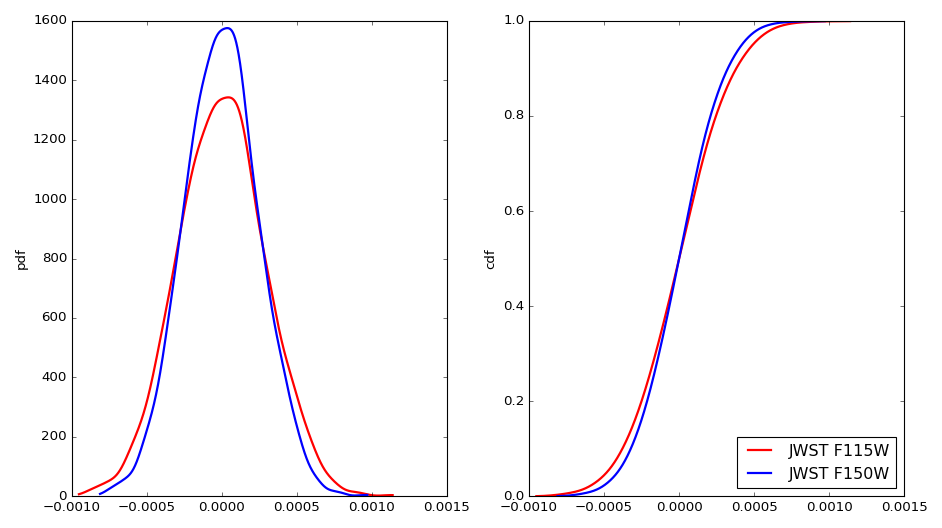

In [75]:
plt.figure(2)

plt.subplot(1,2,1)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x_115,grid_points_pdf_115,c='r',lw=2.)
plt.plot(grid_points_x_150,grid_points_pdf_150,c='b',lw=2.)
plt.ylabel('pdf')

plt.subplot(1,2,2)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.plot(grid_points_x_115,grid_points_cdf_115,c='r',lw=2.,label='JWST F115W')
plt.plot(grid_points_x_150,grid_points_cdf_150,c='b',lw=2.,label='JWST F150W')
plt.ylabel('cdf')
plt.legend(loc='lower right')

In [17]:
nbins_min = 1500

noise_160 = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f160w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]
noise_140 = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f140w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]
noise_125 = fits.open('/home/maryhallow/Desktop/python/Reionizatoin/hlsp_hlf_hst_wfc3-60mas_goodss'
                              '_f125w_v1.0_sci.fits')[0].data[13200:13200+nbins_min,9700:9700+nbins_min]

In [18]:
data_array_160 = np.reshape(noise_160,(nbins_min*nbins_min,))
data_array_140 = np.reshape(noise_140,(nbins_min*nbins_min,))
data_array_125 = np.reshape(noise_125,(nbins_min*nbins_min,))

pdf_160 = stats.gaussian_kde(data_array_160)
pdf_140 = stats.gaussian_kde(data_array_140) 
pdf_125 = stats.gaussian_kde(data_array_125) 

grid_points_x_160 = np.concatenate([np.linspace(np.min(data_array_160),0.03,1000),np.linspace(0.03,1,1000)[1:]])
grid_points_x_140 = np.concatenate([np.linspace(np.min(data_array_140),0.03,1000),np.linspace(0.03,1,1000)[1:]])
grid_points_x_125 = np.concatenate([np.linspace(np.min(data_array_125),0.03,1000),np.linspace(0.03,1,1000)[1:]])

grid_points_pdf_160 = pdf_160.evaluate(grid_points_x_160)
grid_points_pdf_140 = pdf_140.evaluate(grid_points_x_140)
grid_points_pdf_125 = pdf_125.evaluate(grid_points_x_125)

grid_points_cdf_160 = np.zeros_like(grid_points_x_160)
grid_points_cdf_140 = np.zeros_like(grid_points_x_140)
grid_points_cdf_125 = np.zeros_like(grid_points_x_125)

for i in range(0,len(grid_points_x_160)):
    for j in range(1,i+1):
        grid_points_cdf_160[i] += (grid_points_x_160[j]-grid_points_x_160[j-1])*grid_points_pdf_160[j]
        grid_points_cdf_140[i] += (grid_points_x_140[j]-grid_points_x_140[j-1])*grid_points_pdf_140[j]
        grid_points_cdf_125[i] += (grid_points_x_125[j]-grid_points_x_125[j-1])*grid_points_pdf_125[j]

<IPython.core.display.Javascript object>


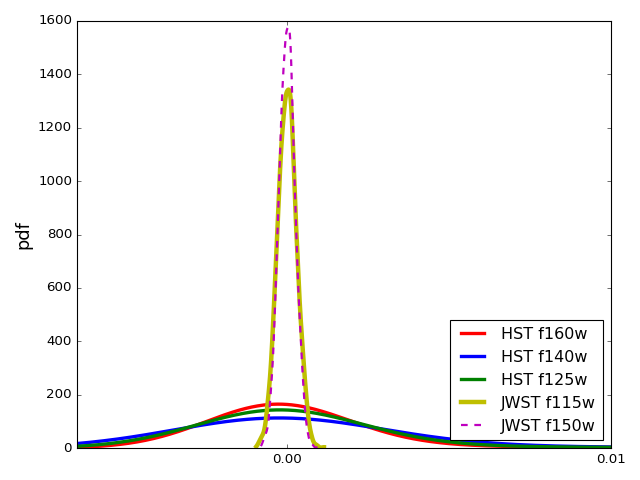

In [76]:
plt.figure(3)

plt.plot(grid_points_x_160,grid_points_pdf_160,c='r',lw=3.,label='HST f160w')
plt.plot(grid_points_x_140,grid_points_pdf_140,c='b',lw=3.,label='HST f140w')
plt.plot(grid_points_x_125,grid_points_pdf_125,c='g',lw=3.,label='HST f125w')
plt.plot(grid_points_x_115,grid_points_pdf_115,c='y',lw=4.,label='JWST f115w')
plt.plot(grid_points_x_150,grid_points_pdf_150,'m--',lw=2.,label='JWST f150w')
plt.xticks(np.array([0.0,0.01,0.02,0.03,0.04]))
plt.xlim(np.max(np.array([np.min(data_array_160),np.min(data_array_140),np.min(data_array_125)])),0.01)
plt.ylabel('pdf',fontsize=16)
plt.legend(loc='lower right')

In [48]:
def f(x,a,b):
    return stats.norm.pdf(x,a,b)

popt_16, pcov_16 = optimize.curve_fit(f,grid_points_x_16[:500],grid_points_pdf_16[:500],bounds=([-0.2,0.0], [0.2, 0.2]))
popt_125, pcov_125 = optimize.curve_fit(f,grid_points_x_125[:500],grid_points_pdf_125[:500],bounds=([-0.2,0.0], [0.2, 0.2]))


print(popt_16)
print(popt_125)

[  1.62979070e-06   1.00155774e-04]
[-0.00020178  0.00239519]


<IPython.core.display.Javascript object>


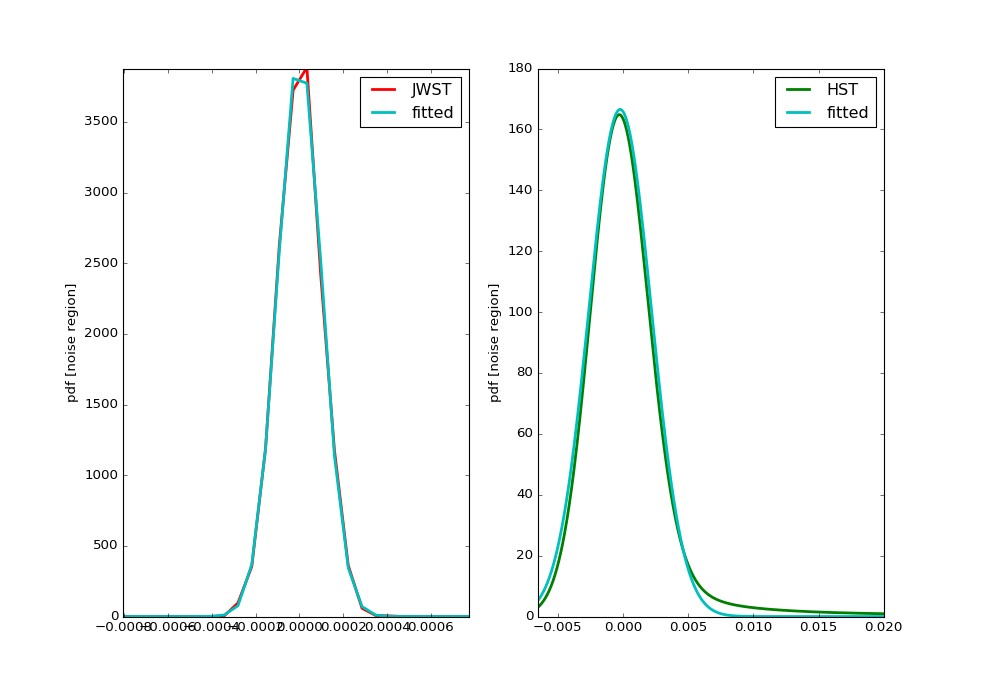

In [49]:

plt.figure(4)

plt.subplot(1,2,1)
plt.plot(grid_points_x_16,grid_points_pdf_16,c='r',lw=2.5,label='JWST')
plt.plot(grid_points_x_16,f(grid_points_x_16,popt_16[0],popt_16[1]),c='c',lw=2.5,label='fitted')
plt.xlim(np.min(data_array_16),np.max(data_array_16)) 
plt.legend(loc='upper right')
plt.ylabel('pdf [noise region]')

plt.subplot(1,2,2)
plt.plot(grid_points_x_125,grid_points_pdf_125,c='g',lw=2.5,label='HST')
plt.plot(grid_points_x_125,f(grid_points_x_125,popt_125[0],popt_125[1]),c='c',lw=2.5,label='fitted')
plt.xlim(np.min(data_array_125),0.02) 
plt.legend(loc='upper right')
plt.ylabel('pdf [noise region]')